# Depression Detection Notebook
This notebook works like a real note sheets.
Success steps are pushed downwards.


In [ ]:
# prompt: help silence warnings

from google.colab import drive
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

#
# # Depression Detection Notebook
# This notebook works like a real note sheets.
# Success steps are pushed downwards.
#

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Detect all PHQ 24 scores using  emotion & prosodic features using tree-based regression and classifier



In [ ]:
# This one is for frame-based emotion
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/EmotionSequenceWprosodyWTargetOutput_.csv', sep='\t') #
merged_df.shape


(934149, 21)

In [ ]:
# This one is for frame-based emotion from data/DAIC_WOZ/tmp_200_speakers/EmotionSequenceWprosodyWTargetOutput_.csv
Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])
# Y_PHQ_emoWprosody_seq

In [ ]:
merged_df.columns

Index(['File', 'Emotion_num', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'Neutral', 'Happy',
       'Sad', 'Angry', 'Participant_ID', 'AVECParticipant_ID', 'Gender',
       'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity',
       'DecisionTreeRegressor_pred', 'DecisionTreeClassifier_pred',
       'RandomForestRegressor_pred', 'RandomForestClassifier_pred',
       'Neutral_pre_diff', 'Neutral_post_diff', 'Happy_pre_diff',
       'Happy_post_diff', 'Sad_pre_diff', 'Sad_post_diff', 'Angry_pre_diff',
       'Angry_post_diff'],
      dtype='object')

In [ ]:
# prompt: Create X_train X_test y_train y_test by consider 'Participant_ID'. If it starts with 'training_', it is in train set. If it starts with 'deveplopment', it is in test set.

def split_data(X_PHQ_emoWprosody_seq,Y_PHQ_emoWprosody_seq):

    # Split the data based on 'AVECParticipant_ID'
    train_indices = X_PHQ_emoWprosody_seq[X_PHQ_emoWprosody_seq['AVECParticipant_ID'].str.startswith('training_')].index
    test_indices = X_PHQ_emoWprosody_seq[X_PHQ_emoWprosody_seq['AVECParticipant_ID'].str.startswith('development_')].index



    X_train = X_PHQ_emoWprosody_seq.drop(columns=['AVECParticipant_ID']).iloc[train_indices]
    X_test = X_PHQ_emoWprosody_seq.drop(columns=['AVECParticipant_ID']).iloc[test_indices]
    y_train = Y_PHQ_emoWprosody_seq.iloc[train_indices]
    y_test = Y_PHQ_emoWprosody_seq.iloc[test_indices]

    return X_train, X_test, y_train, y_test, train_indices, test_indices

In [ ]:
# prompt: using  sklearn DecisionTreeRegressor, DecisionTreeClassifier, RandomForestRegressor and RandomForestClassifier to get Accuracy, RMSE, MAE and Classification Report. Add pred result as {model_name}'_pred' to merged_df. Save the pred dataframe

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report
import numpy as np

# Define a function to evaluate models and store predictions
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_indices, test_indices, merged_df,):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    merged_df[f'{model_name}_pred'] = np.nan
    merged_df.loc[test_indices, f'{model_name}_pred'] = y_pred


    if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
        accuracy = accuracy_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f'{model_name} RMSE: {rmse}')
        print(f'{model_name} Accuracy: {accuracy}')
        # if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
        print(f'{model_name} Classification Report:\n{classification_report(y_test, np.round(y_pred))}')
    else:  # Regression models
        # accuracy = accuracy_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        print(f'{model_name} RMSE: {rmse}')
        print(f'{model_name} MAE: {mae}')

    return merged_df

# Initialize and evaluate models
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestRegressor': RandomForestRegressor(),
    'RandomForestClassifier': RandomForestClassifier()
}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = split_data(X_PHQ_emoWprosody_seq,Y_PHQ_emoWprosody_seq)
    merged_df = evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_indices, test_indices , merged_df)

# Save the updated DataFrame
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/frameEmoPredictions.csv', sep='\t', index=False)

DecisionTreeRegressor RMSE: 8.721601680387153
DecisionTreeRegressor MAE: 6.996843185901275
DecisionTreeClassifier RMSE: 8.63871726884195
DecisionTreeClassifier Accuracy: 0.056715715630079565


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.13      0.12     27832
           1       0.08      0.12      0.09     13132
           2       0.11      0.08      0.10     23325
           3       0.04      0.10      0.06      7105
           4       0.06      0.03      0.04     15729
           5       0.04      0.11      0.05      5390
           6       0.01      0.00      0.01     12495
           7       0.05      0.08      0.06     12789
           8       0.05      0.01      0.02     15337
           9       0.08      0.03      0.04     27244
          10       0.00      0.00      0.00      3920
          11       0.19      0.02      0.03     23765
          12       0.13      0.07      0.09     15778
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.03      0.01  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.27      0.17     27832
           1       0.10      0.21      0.13     13132
           2       0.15      0.12      0.13     23325
           3       0.02      0.04      0.03      7105
           4       0.03      0.01      0.01     15729
           5       0.02      0.08      0.04      5390
           6       0.00      0.00      0.00     12495
           7       0.01      0.02      0.01     12789
           8       0.12      0.01      0.01     15337
           9       0.05      0.01      0.02     27244
          10       0.00      0.00      0.00      3920
          11       0.18      0.01      0.02     23765
          12       0.15      0.06      0.08     15778
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.05      0.01  

In [ ]:
emotions = ['Neutral', 'Happy', 'Sad', 'Angry']
for emotion in emotions:
  # Calculate pre_diff
  merged_df[f'{emotion}_pre_diff'] = merged_df[emotion].diff()
  # Calculate post_diff
  merged_df[f'{emotion}_post_diff'] = merged_df[emotion].diff(-1)

In [ ]:
merged_df.columns

Index(['File', 'Emotion_num', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'Neutral', 'Happy',
       'Sad', 'Angry', 'Participant_ID', 'AVECParticipant_ID', 'Gender',
       'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity',
       'DecisionTreeRegressor_pred', 'DecisionTreeClassifier_pred',
       'RandomForestRegressor_pred', 'RandomForestClassifier_pred',
       'Neutral_pre_diff', 'Neutral_post_diff', 'Happy_pre_diff',
       'Happy_post_diff', 'Sad_pre_diff', 'Sad_post_diff', 'Angry_pre_diff',
       'Angry_post_diff'],
      dtype='object')

In [ ]:
Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Emotion_num', 'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity'])

In [ ]:
# For frame-based emo + transition
# Initialize and evaluate models
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestRegressor': RandomForestRegressor(),
    'RandomForestClassifier': RandomForestClassifier()
}

for model_name, model in models.items():
    print(f"\n> Evaluating {model_name}...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = split_data(X_PHQ_emoWprosody_seq,Y_PHQ_emoWprosody_seq)
    merged_df = evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_indices, test_indices , merged_df)

# Save the updated DataFrame
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/frameEmo+TransPredictions.csv', sep='\t', index=False)

Evaluating DecisionTreeRegressor...
DecisionTreeRegressor RMSE: 8.679331420610872
DecisionTreeRegressor MAE: 6.955458123021645
Evaluating DecisionTreeClassifier...
DecisionTreeClassifier RMSE: 8.724174701821747
DecisionTreeClassifier Accuracy: 0.05231841902643511
DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.13      0.11     27832
           1       0.07      0.12      0.09     13132
           2       0.09      0.08      0.08     23325
           3       0.04      0.09      0.05      7105
           4       0.07      0.03      0.04     15729
           5       0.02      0.07      0.04      5390
           6       0.06      0.02      0.03     12495
           7       0.03      0.05      0.04     12789
           8       0.04      0.01      0.01     15337
           9       0.07      0.02      0.03     27244
          10       0.00      0.00      0.00      3920
          11       0.19      0.02      0.

In [ ]:
# This is for pharse-level emotion by avr scores
# data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv
import pandas as pd
merged_df = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv', sep='\t')
df_target = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/metadata_mapped.csv')
merged_df = pd.merge(merged_df, df_target, left_on='File', right_on='Participant_ID', how='inner')
merged_df = merged_df.dropna()


In [ ]:
# for pharse-level emotion by avr scores
# Initialize and evaluate models
models = {
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestRegressor': RandomForestRegressor(),
    'RandomForestClassifier': RandomForestClassifier()
}

for model_name, model in models.items():
    print(f"\n Evaluating {model_name}...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = split_data(X_PHQ_emoWprosody_seq,Y_PHQ_emoWprosody_seq)
    merged_df = evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_indices, test_indices , merged_df)

# Save the updated DataFrame
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/phraseEmoPredictions.csv', sep='\t', index=False)


 Evaluating DecisionTreeRegressor...
DecisionTreeRegressor RMSE: 8.664185225172295
DecisionTreeRegressor MAE: 6.943210393964795

 Evaluating DecisionTreeClassifier...
DecisionTreeClassifier RMSE: 8.608267142811714
DecisionTreeClassifier Accuracy: 0.05322715842414082
DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.13      0.12       568
           1       0.08      0.12      0.09       268
           2       0.09      0.07      0.08       477
           3       0.04      0.10      0.06       145
           4       0.03      0.02      0.02       321
           5       0.03      0.09      0.04       110
           6       0.03      0.01      0.02       255
           7       0.03      0.05      0.04       261
           8       0.12      0.02      0.04       313
           9       0.08      0.03      0.05       556
          10       0.01      0.03      0.01        80
          11       0.31      0.03    

In [ ]:
# for pharse-level emotion by avr scores + emo transition
emotions = ['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']
for emotion in emotions:
  # Calculate pre_diff
  merged_df[f'{emotion}_pre_diff'] = merged_df[emotion].diff()
  # Calculate post_diff
  merged_df[f'{emotion}_post_diff'] = merged_df[emotion].diff(-1)
merged_df.columns

Index(['File', 'Text', 'Emotion', 'avg_Neutral', 'avg_Happy', 'avg_Sad',
       'avg_Angry', 'Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'Participant_ID',
       'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score',
       'PCL-C (PTSD)', 'PTSD Severity', 'avg_Neutral_pre_diff',
       'avg_Neutral_post_diff', 'avg_Happy_pre_diff', 'avg_Happy_post_diff',
       'avg_Sad_pre_diff', 'avg_Sad_post_diff', 'avg_Angry_pre_diff',
       'avg_Angry_post_diff'],
      dtype='object')

In [ ]:
# for pharse-level emotion by avr scores + emo transition

Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
# This for phrase-level emotion with transition
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Text', 'Emotion','Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Participant_ID',
       'Gender', 'PHQ_Binary', 'PHQ_Score',
       'PCL-C (PTSD)', 'PTSD Severity'])
print(X_PHQ_emoWprosody_seq.shape)
print(X_PHQ_emoWprosody_seq.columns)


for model_name, model in models.items():
    print(f"\n Evaluating {model_name}...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = split_data(X_PHQ_emoWprosody_seq,Y_PHQ_emoWprosody_seq)
    merged_df = evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_indices, test_indices , merged_df)

# Save the updated DataFrame
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/phraseEmo+transitionPredictions.csv', sep='\t', index=False)

(19077, 21)
Index(['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry', 'Mean Pitch (Hz)',
       'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)',
       'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)',
       'AVECParticipant_ID', 'avg_Neutral_pre_diff', 'avg_Neutral_post_diff',
       'avg_Happy_pre_diff', 'avg_Happy_post_diff', 'avg_Sad_pre_diff',
       'avg_Sad_post_diff', 'avg_Angry_pre_diff', 'avg_Angry_post_diff'],
      dtype='object')

 Evaluating DecisionTreeRegressor...
DecisionTreeRegressor RMSE: 8.678045059341985
DecisionTreeRegressor MAE: 6.96940486169321

 Evaluating DecisionTreeClassifier...
DecisionTreeClassifier RMSE: 8.547694208281554
DecisionTreeClassifier Accuracy: 0.056789606035205366
DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.14      0.13       568
           1       0.06      0.10      0.08       268
           2       0.09      0.07      

In [ ]:
# prompt: For each of merged_df[['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry']], add pre_diff and pre-1_diff columns from different value with the previous row and the row before, also add post_diff and post+1_diff columns from different value with the next row and the row after.

for emotion in emotions:
  # Calculate pre_diff and pre-1_diff
  merged_df[f'{emotion}_pre_diff'] = merged_df[emotion].diff()
  merged_df[f'{emotion}_pre_1_diff'] = merged_df[emotion].diff(periods=2)
  # Calculate post_diff and post+1_diff
  merged_df[f'{emotion}_post_diff'] = merged_df[emotion].diff(-1)
  merged_df[f'{emotion}_post_1_diff'] = merged_df[emotion].diff(periods=-2)
meraged_df = merged_df.dropna()

In [ ]:
meraged_df.columns

Index(['File', 'Text', 'Emotion', 'avg_Neutral', 'avg_Happy', 'avg_Sad',
       'avg_Angry', 'Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Mean Pitch (Hz)', 'Pitch SD (Hz)',
       'Mean Intensity (dB)', 'Intensity SD (dB)', 'Jitter (local) (%)',
       'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)', 'Participant_ID',
       'AVECParticipant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score',
       'PCL-C (PTSD)', 'PTSD Severity', 'avg_Neutral_pre_diff',
       'avg_Neutral_pre_1_diff', 'avg_Neutral_post_diff',
       'avg_Neutral_post_1_diff', 'avg_Happy_pre_diff', 'avg_Happy_pre_1_diff',
       'avg_Happy_post_diff', 'avg_Happy_post_1_diff', 'avg_Sad_pre_diff',
       'avg_Sad_pre_1_diff', 'avg_Sad_post_diff', 'avg_Sad_post_1_diff',
       'avg_Angry_pre_diff', 'avg_Angry_pre_1_diff', 'avg_Angry_post_diff',
       'avg_Angry_post_1_diff'],
      dtype='object')

In [ ]:
# for pharse-level emotion by avr scores + emo transition size 2

Y_PHQ_emoWprosody_seq = merged_df['PHQ_Score'].fillna(-1)
# This for phrase-level emotion with transition
X_PHQ_emoWprosody_seq = merged_df.drop(columns=['File', 'Text', 'Emotion','Interval Number', 'Interval Start (s)',
       'Interval End (s)', 'Participant_ID',
       'Gender', 'PHQ_Binary', 'PHQ_Score',
       'PCL-C (PTSD)', 'PTSD Severity'])
print(X_PHQ_emoWprosody_seq.shape)
print(X_PHQ_emoWprosody_seq.columns)


for model_name, model in models.items():
    print(f"\n Evaluating {model_name}...")
    X_train, X_test, y_train, y_test, train_indices, test_indices = split_data(X_PHQ_emoWprosody_seq,Y_PHQ_emoWprosody_seq)
    merged_df = evaluate_model(model, model_name, X_train, y_train, X_test, y_test, train_indices, test_indices , merged_df)

# Save the updated DataFrame
merged_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/tmp_200_speakers/phraseEmo+transition2Predictions.csv', sep='\t', index=False)

(19077, 29)
Index(['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry', 'Mean Pitch (Hz)',
       'Pitch SD (Hz)', 'Mean Intensity (dB)', 'Intensity SD (dB)',
       'Jitter (local) (%)', 'Shimmer (local) (%)', 'HNR (dB)', 'Duration (s)',
       'AVECParticipant_ID', 'avg_Neutral_pre_diff', 'avg_Neutral_pre_1_diff',
       'avg_Neutral_post_diff', 'avg_Neutral_post_1_diff',
       'avg_Happy_pre_diff', 'avg_Happy_pre_1_diff', 'avg_Happy_post_diff',
       'avg_Happy_post_1_diff', 'avg_Sad_pre_diff', 'avg_Sad_pre_1_diff',
       'avg_Sad_post_diff', 'avg_Sad_post_1_diff', 'avg_Angry_pre_diff',
       'avg_Angry_pre_1_diff', 'avg_Angry_post_diff', 'avg_Angry_post_1_diff'],
      dtype='object')

 Evaluating DecisionTreeRegressor...
DecisionTreeRegressor RMSE: 8.550954221934305
DecisionTreeRegressor MAE: 6.850167644593462

 Evaluating DecisionTreeClassifier...
DecisionTreeClassifier RMSE: 8.498089129917194
DecisionTreeClassifier Accuracy: 0.053646269907795474
DecisionTreeClassifier Classif

## Plot

In [ ]:
merged__emo_prosodic_df.to_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/01_Merged_emo_prosodic_df.csv', sep='\t', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-56-bbd805fcddb0>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout() # Adjust layout to prevent labels from overlapping


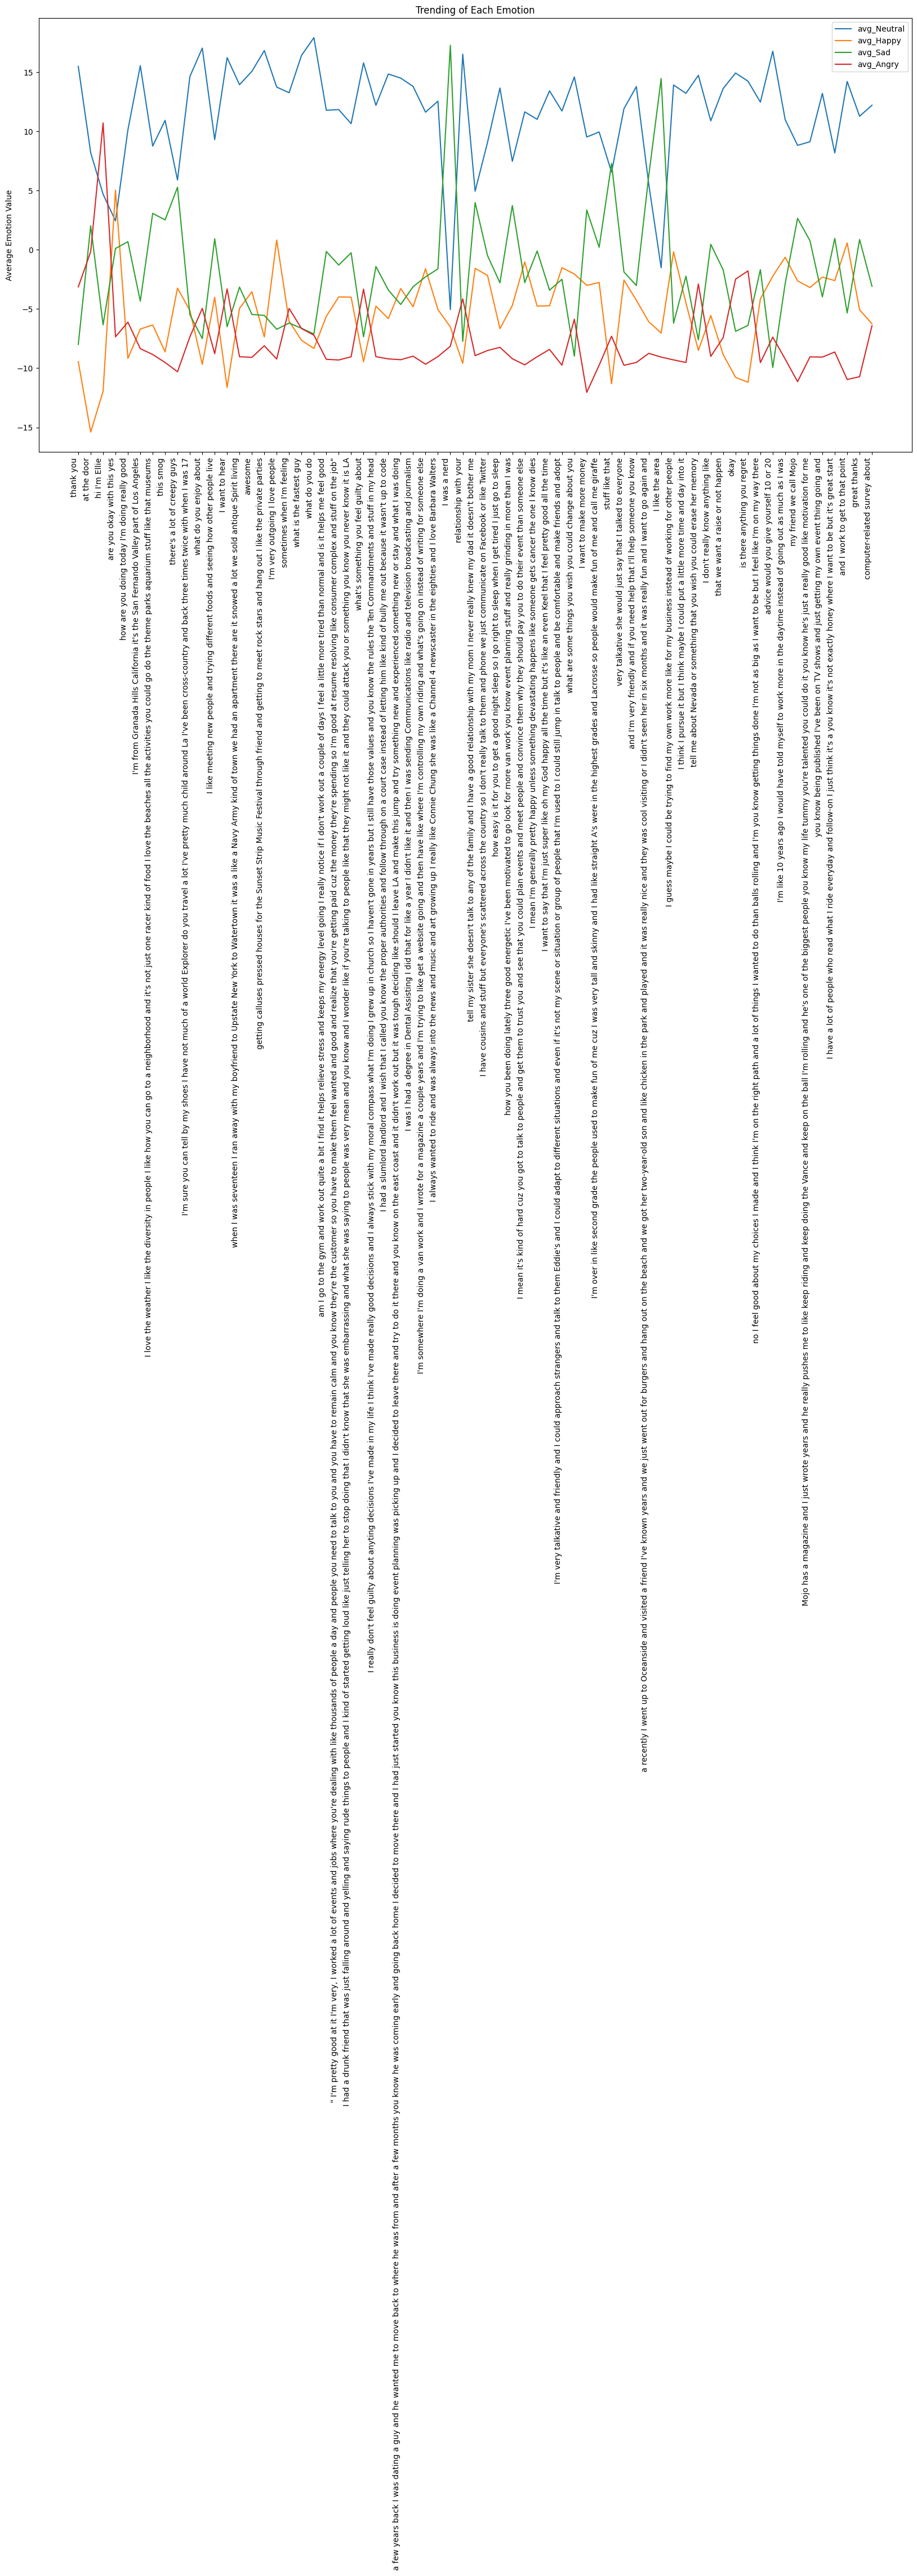

In [ ]:
import matplotlib.pyplot as plt

# Reshape the data for plotting
df_melted = df_new.melt(id_vars=['Text'], value_vars=['avg_Neutral', 'avg_Happy', 'avg_Sad', 'avg_Angry'], var_name='Emotion', value_name='Value')

# Create the line plot
plt.figure(figsize=(20, 10))  # Adjust figure size as needed
for emotion in df_melted['Emotion'].unique():
  plt.plot(df_melted[df_melted['Emotion'] == emotion]['Text'], df_melted[df_melted['Emotion'] == emotion]['Value'], label=emotion)

plt.ylabel('Average Emotion Value')
plt.title('Trending of Each Emotion')
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
df_target = pd.read_csv('/content/drive/MyDrive/CS5647 Sound/CS5647_Project/data/DAIC_WOZ/metadata_mapped.csv')

In [ ]:
from matplotlib import pyplot as plt

df_target

,Participant_ID,AVECParticipant_ID,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,training_001,male,0,4,0,28
1,303,training_002,female,0,0,0,17
2,304,training_003,female,0,6,0,20
3,305,training_004,male,0,7,0,28
4,307,training_005,female,0,4,0,23
...,...,...,...,...,...,...,...
214,667,development_52,male,0,3,0,23
215,670,development_53,male,0,0,0,21
216,687,development_54,male,0,7,1,44
217,698,development_55,male,1,19,1,60


<Figure size 640x480 with 0 Axes>

from matplotlib import pyplot as plt
df_target['Participant_ID'].plot(kind='hist', bins=20, title='Participant_ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Binary'].plot(kind='hist', bins=20, title='PHQ_Binary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Score'].plot(kind='hist', bins=20, title='PHQ_Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['PCL-C (PTSD)'].plot(kind='hist', bins=20, title='PCL-C (PTSD)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_target.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='Participant_ID', y='PHQ_Binary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='PHQ_Binary', y='PHQ_Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='PHQ_Score', y='PCL-C (PTSD)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target.plot(kind='scatter', x='PCL-C (PTSD)', y='PTSD Severity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_target['Participant_ID'].plot(kind='line', figsize=(8, 4), title='Participant_ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Binary'].plot(kind='line', figsize=(8, 4), title='PHQ_Binary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_target['PHQ_Score'].plot(kind='line', figsize=(8, 4), title='PHQ_Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_target['PCL-C (PTSD)'].plot(kind='line', figsize=(8, 4), title='PCL-C (PTSD)')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='Participant_ID', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='PHQ_Binary', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='PHQ_Score', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_target['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_target, x='PCL-C (PTSD)', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<Axes: title={'center': 'PHQ_Binary'}, ylabel='Frequency'>

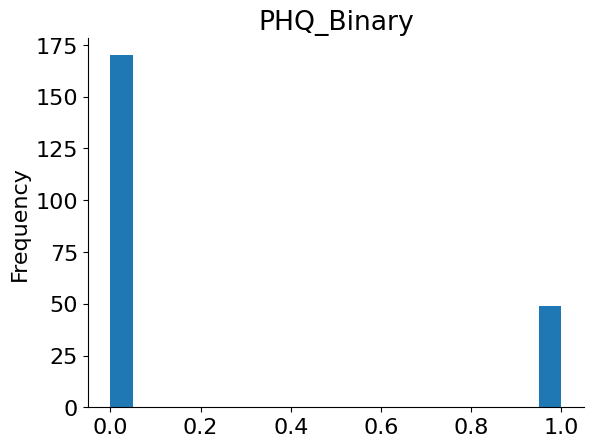

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.rcParams.update({'font.size': 16}) # must set in top
plt.gca().spines[['top', 'right',]].set_visible(False)
df_target['PHQ_Binary'].plot(kind='hist', bins=20, title='PHQ_Binary')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.show()


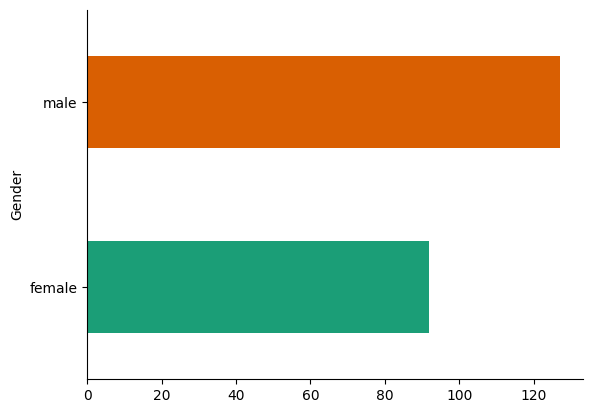

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_target.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

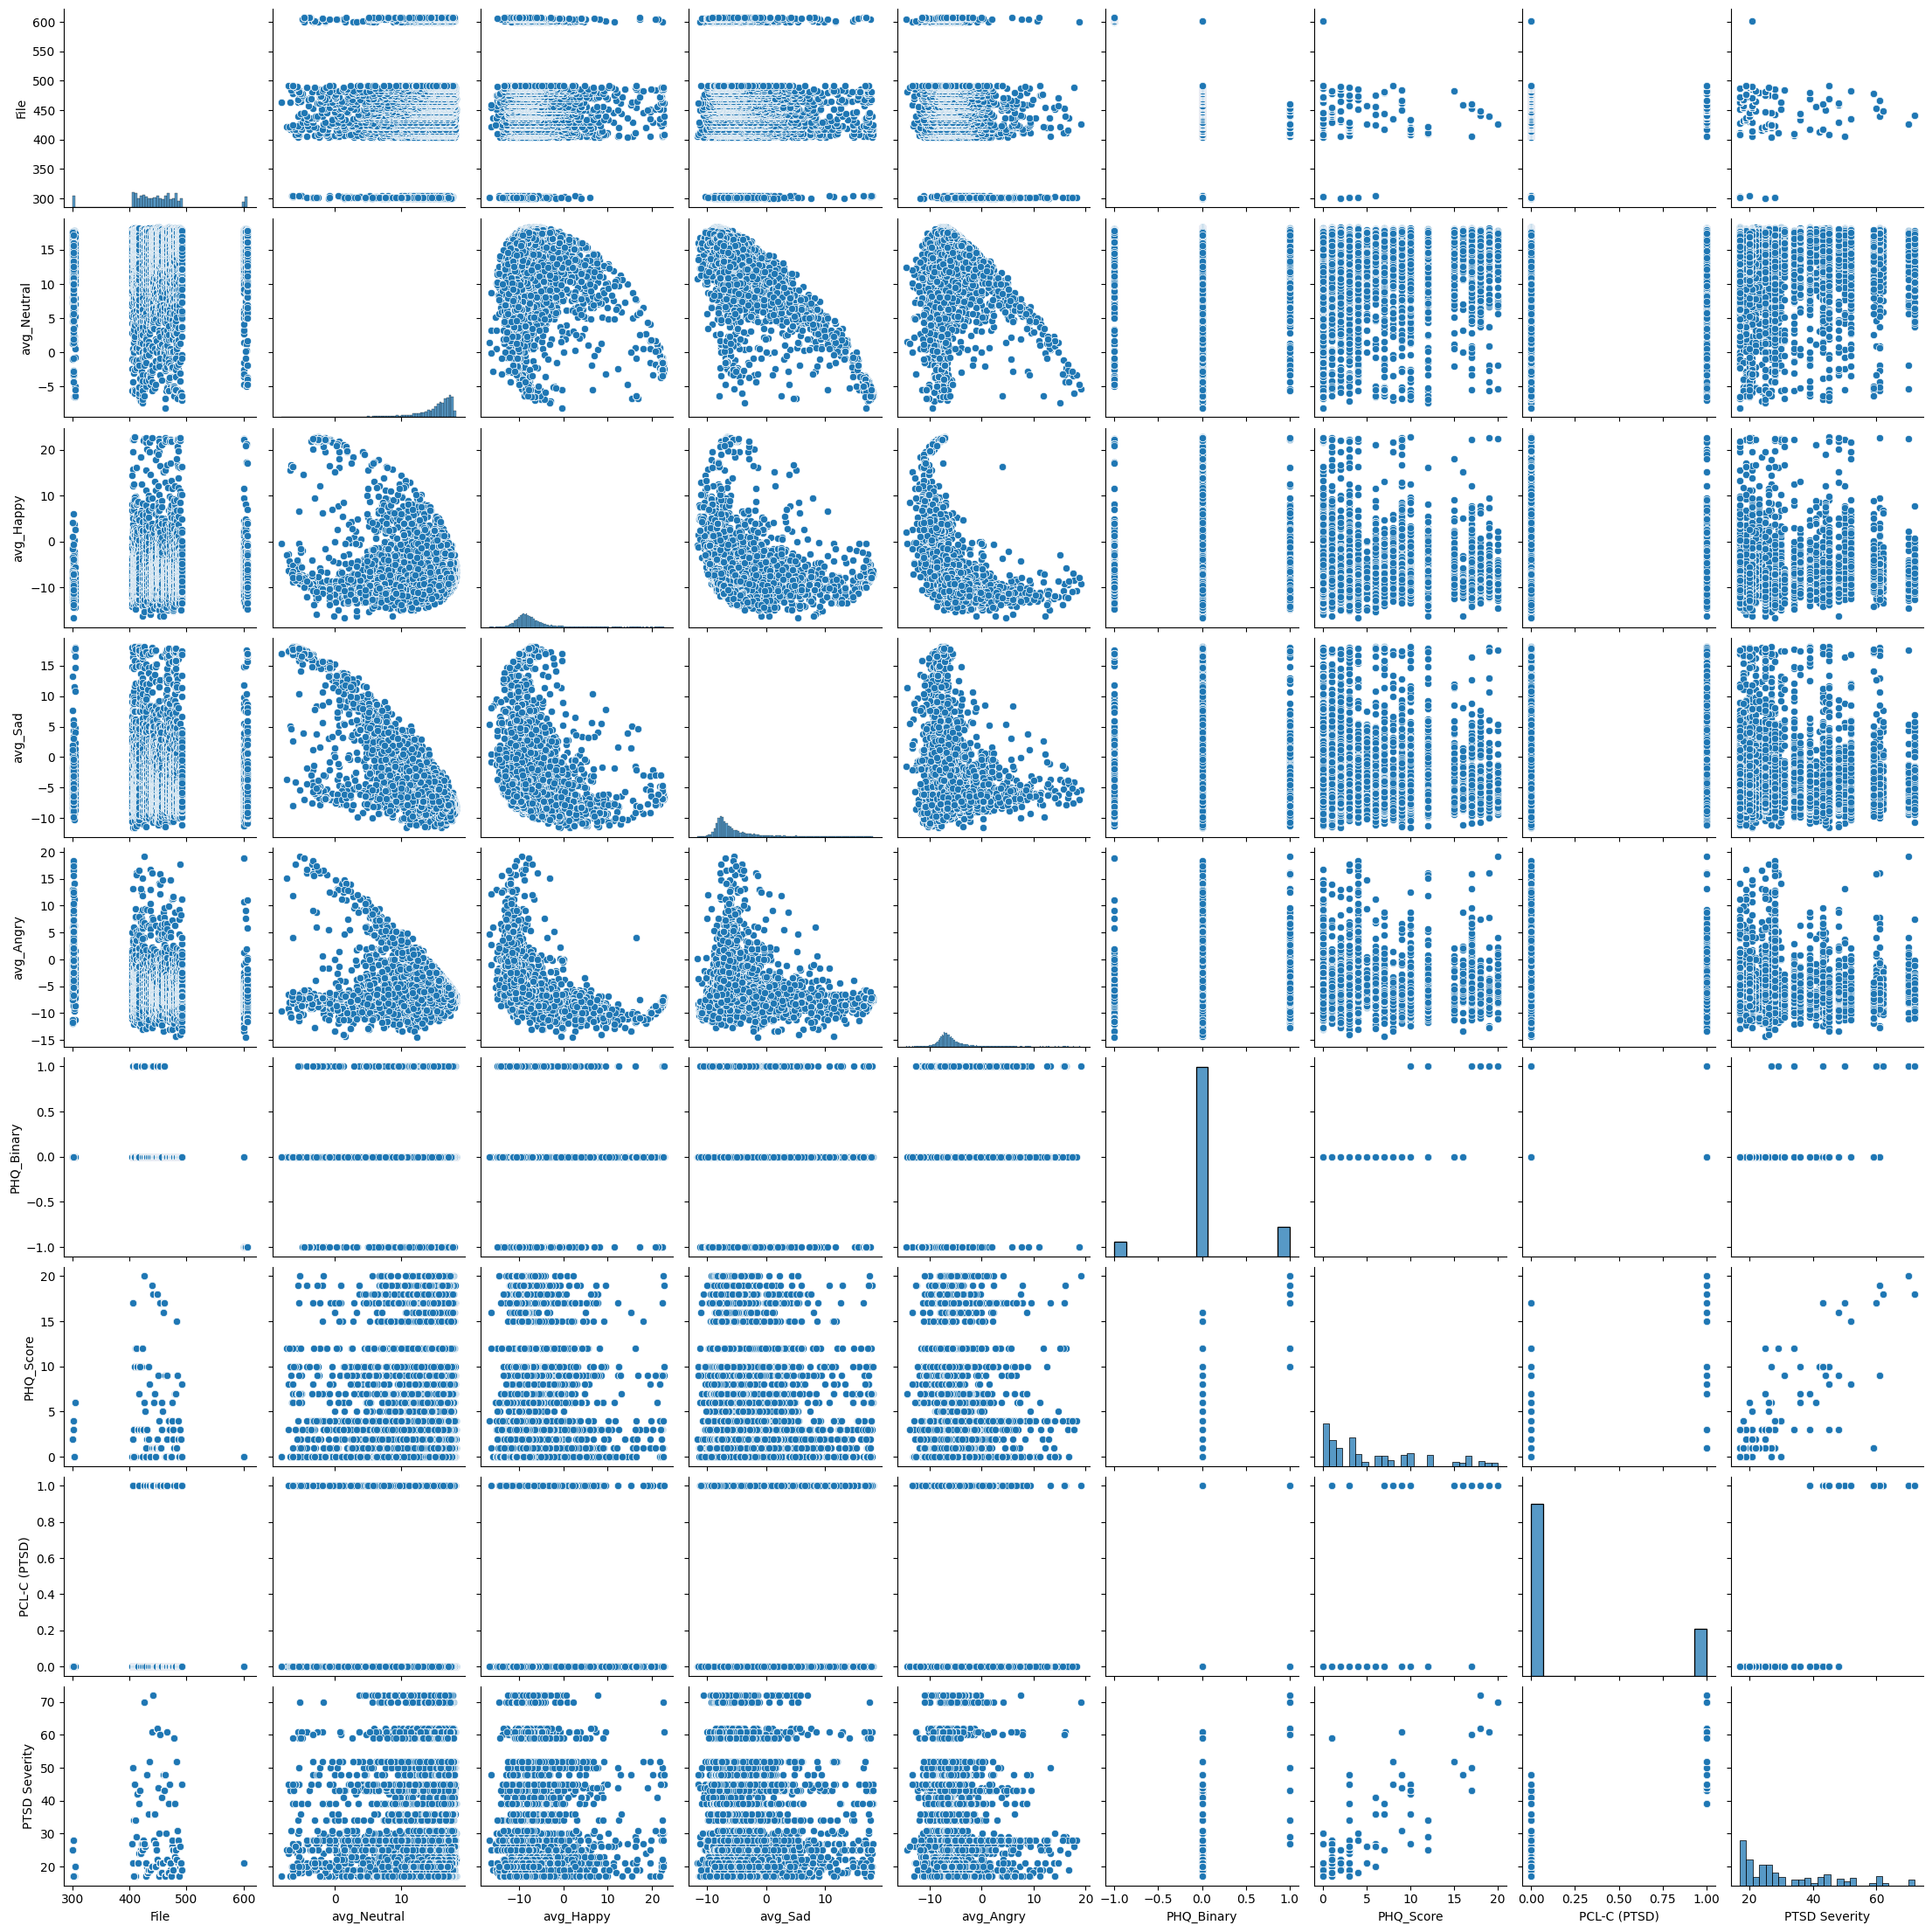

In [ ]:
sns.pairplot(merged__emo_prosodic_df[['File','avg_Neutral', 'avg_Happy', 'avg_Sad',
       'avg_Angry', 'PHQ_Binary',
       'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']])
plt.show()

In [ ]:
Y_Score = merged__emo_prosodic_df['PHQ_Score'].fillna(-1)

<Axes: ylabel='Frequency'>

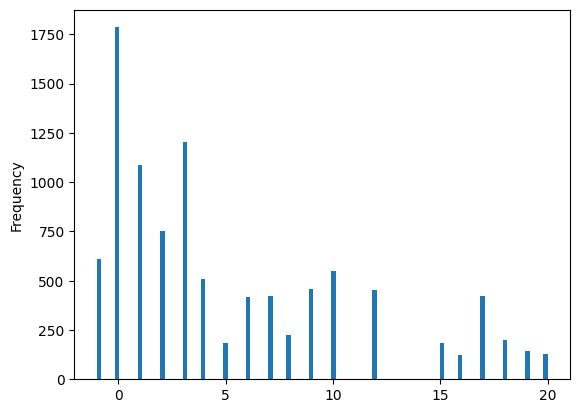

In [ ]:
Y_Score.plot(kind='hist', bins=100)

In [ ]:
merged__emo_prosodic_df[['avg_Happy', 'avg_Sad', 'avg_Angry', 'avg_Neurtal']]

,File,Text,Emotion,avg_Neutral,avg_Happy,avg_Sad,avg_Angry,Interval Number,Interval Start (s),Interval End (s),...,Mean Intensity (dB),Intensity SD (dB),Jitter (local) (%),Shimmer (local) (%),HNR (dB),Duration (s),PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,405.0,essential let you know and then you can let me...,"[[14.18704605102539, -9.37901782989502, -3.045...",14.325210,-9.403361,-3.037173,-6.728367,1,18.5,22.3,...,37.495166,10.447007,0.017625,0.075467,17.328332,3.8,1.0,17.0,1.0,50.0
1,405.0,thanks,"[[16.3295955657959, -8.033401489257812, -7.942...",16.111670,-7.742381,-7.976411,-4.962175,2,23.7,24.4,...,34.553041,8.173891,0.054081,0.149123,10.006434,0.7,1.0,17.0,1.0,50.0
2,405.0,go ahead and move his cord behind you didn't g...,"[[15.299209594726562, -6.708323001861572, -7.8...",15.490749,-6.789825,-8.094583,-4.434079,3,26.8,29.9,...,35.903733,5.361039,0.038445,0.234513,6.314799,3.1,1.0,17.0,1.0,50.0
3,405.0,hi hello,"[[9.37299633026123, -3.9227797985076904, 1.430...",9.308572,-4.255228,1.608068,-10.622124,4,37.8,38.8,...,31.784618,10.846122,0.008004,0.039994,19.777981,1.0,1.0,17.0,1.0,50.0
4,405.0,are you okay with this,"[[9.678568840026855, -11.853007316589355, -6.2...",9.827066,-11.662124,-6.177302,3.665494,5,58,59.2,...,27.765436,5.412659,0.023921,0.174085,8.358552,1.2,1.0,17.0,1.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,302.0,thank you,"[[9.57912540435791, -11.20682144165039, -7.493...",9.228908,-11.353075,-7.252645,5.217466,89,650,650.7,...,43.476501,4.778545,0.051874,0.196071,4.817835,0.7,0.0,4.0,0.0,28.0
9842,302.0,thank you,"[[9.57912540435791, -11.20682144165039, -7.493...",9.228908,-11.353075,-7.252645,5.217466,95,709.8,710.5,...,42.415271,4.455350,0.032094,0.152198,2.972136,0.7,0.0,4.0,0.0,28.0
9843,302.0,Bubba,"[[15.642026901245117, -9.462481498718262, -7.2...",15.622512,-9.524224,-7.229807,-3.879265,96,711.4,712,...,45.029416,5.796919,0.048994,0.182117,4.760564,0.6,0.0,4.0,0.0,28.0
9844,302.0,why was talking,"[[10.204808235168457, -13.773117065429688, -5....",9.966529,-13.668185,-5.037328,3.627563,97,745.9,747.1,...,45.550620,4.747722,0.017625,0.187785,2.719357,1.2,0.0,4.0,0.0,28.0
